## Import libraries

In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import dsa
from dsa import *
from datasets import image
from models import mlp
from models import resnet
import pickle
from sklearn.model_selection import train_test_split

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

xy = np.loadtxt("../datasets/wine-white.csv", delimiter=";")
np.random.shuffle(xy)
x = xy[:,0:-1]
y = xy[:,-1]-3

min_values = np.array([min(x[:,i]) for i in range(x.shape[1])])
max_values = np.array([max(x[:,i]) for i in range(x.shape[1])])
x = (x-min_values)/(max_values - min_values)
y = y.reshape((len(x), 1)).astype("float32")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

target_ds = make_dataset(x_train, y_train, lambda t: t)
aux_ds = make_dataset(x_test, y_test, lambda t: t)

2022-02-27 18:03:02.089860: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-27 18:03:02.089951: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xgpd1
2022-02-27 18:03:02.089985: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xgpd1
2022-02-27 18:03:02.090195: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.91.3
2022-02-27 18:03:02.090250: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.91.3
2022-02-27 18:03:02.090266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.91.3
2022-02-27 18:03:02.090968: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfor

In [4]:
wine_dsa = {}
log = {}

for split in [2,3,4]:
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=11, class_num=7, split=split, units=64, act="relu")
    wine_dsa["wine-split="+str(split)] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log["wine-split="+str(split)] = wine_dsa["wine-split="+str(split)].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        batch_size=64,
        iterations=1000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.0001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.0001,
        lr_c=0.0001,
        iter_d=20,   # the number of iterations to train the decoder on auxiliary data
        w=500.,
        verbose=True,
        log_freq=50)

======Split level is 2======
Iteration 50, average attack MSE: 0.028383739553391935
Iteration 100, average attack MSE: 0.008093234552070498
Iteration 150, average attack MSE: 0.005807148199528456
Iteration 200, average attack MSE: 0.004445937061682344
Iteration 250, average attack MSE: 0.0033663655491545795
Iteration 300, average attack MSE: 0.002720616632141173
Iteration 350, average attack MSE: 0.002209345055744052
Iteration 400, average attack MSE: 0.0018563886196352542
Iteration 450, average attack MSE: 0.001366665093228221
Iteration 500, average attack MSE: 0.0011681792698800563
Iteration 550, average attack MSE: 0.000934605048969388
Iteration 600, average attack MSE: 0.0007660865946672857
Iteration 650, average attack MSE: 0.000658001457923092
Iteration 700, average attack MSE: 0.0005903816979844123
Iteration 750, average attack MSE: 0.0005439896869938821
Iteration 800, average attack MSE: 0.0005307528655976057
Iteration 850, average attack MSE: 0.0004852230503456667
Iteration 90

In [5]:
with open('log/wine.pkl', 'wb') as f:
    pickle.dump(log, f)

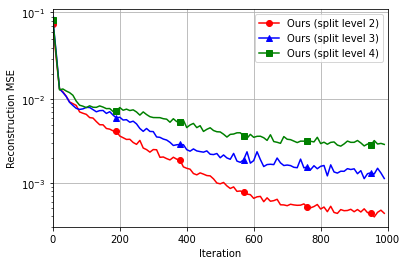

In [28]:
with open('log/wine.pkl', 'rb') as f:
    log = pickle.load(f)

from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 10
plt.yscale('logit')
plt.xlim([0,1000])
plt.grid()
sampled_log_2 = [sum(log["wine-split=2"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["wine-split=2"][:,0])/log_freq))]
sampled_log_3 = [sum(log["wine-split=3"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["wine-split=3"][:,0])/log_freq))]
sampled_log_4 = [sum(log["wine-split=4"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["wine-split=4"][:,0])/log_freq))]
ran = [i * log_freq for i in range(int(1000/log_freq))]
plt.plot(ran, sampled_log_2, 'ro-', ran, sampled_log_3, 'b^-', ran, sampled_log_4, 'gs-', markevery=19)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Iteration')
plt.legend(["Ours (split level 2)", "Ours (split level 3)", "Ours (split level 4)"])
plt.savefig("fig/wine-all.pdf", bbox_inches='tight')

Seems all right!